# Plots related to comparison of different IFN-inducing mutants
This R Jupyter notebook makes nice versions of qPCR and flow cytometry summary plots that compare IFN induction among different mutants.

## Import packages and define functions
Set up for plotting:

In [1]:
# install R packages
r_packages <- c(
  "tidyverse", "cowplot", "IRdisplay", "scales")
suppressMessages(invisible(
  lapply(r_packages, library, character.only=TRUE)))

# http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/#a-colorblind-friendly-palette
# The palette with grey:
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", 
               "#0072B2", "#D55E00", "#CC79A7")

saveShowPlot <- function(p, width, height, plotname=NA) {
  if (is.na(plotname))
    plotname <- gsub("\\.", "_", deparse(substitute(p))) 
  pngfile <- sprintf("%s.png", plotname)
  pdffile <- sprintf("%s.pdf", plotname)
  ggsave(pngfile, plot=p, width=width, height=height, units="in")
  ggsave(pdffile, plot=p, width=width, height=height, units="in")
  display_png(file=pngfile)
}

fancy_scientific <- function(x, parse.str=TRUE, digits=NULL) {
  # scientific notation formatting, based loosely on https://stackoverflow.com/a/24241954
  # if `parse.str` is TRUE, then we parse the string into an expression
  # `digits` indicates how many digits to include
  x %>% format(scientific=TRUE, digits=digits) %>% gsub("^0e\\+00","0", .) %>%
    gsub("^1e\\+00", "1", .) %>% gsub("^(.*)e", "'\\1'e", .) %>% 
    gsub("e\\+","e", .) %>% gsub("e", "%*%10^", .) %>%
    gsub("^\'1\'\\%\\*\\%", "", .) %>% {if (parse.str) parse(text=.) else .}
}

## qPCR plots
First, we make plots for qPCR data.

### Cells that have been treated with cycloheximide
Read in the data.
We set a detection limit based on when measurements appear to be noise, and set points lower than that to limit.

In [2]:
# samples of interest
qPCR_samples <- c("uninfected", "NS1stop", "PB1del\n385to2163")

# set detection limit, and any points below it to that limit
qPCR_limit <- 1e-4

# read and clean up data
cyclo_qPCR <- read.csv('qPCR/cycloheximide.csv') %>%
  mutate(
    Sample=recode(Sample,
      `NS1*`="NS1stop",
      Uninfected="uninfected",
      PB1d1="PB1del\n385to2163"
      ),
    Cycloheximide=recode(Cycloheximide,
      No="- cycloheximide",
      Yes="+ cycloheximide"
      )
    ) %>%
  filter(Sample %in% qPCR_samples) %>%
  transform(Sample=factor(Sample, qPCR_samples)) %>%
  mutate(IFNB1=pmax(IFNB1, qPCR_limit))

Now plot IFN induction +/- cycloheximide.
This shows that in general (i.e., for uninfected cells), cycloheximide leads to an increase in IFN.
But for the NS1stop virus, this increase is outweighed by the block in secondary transcription.
In contrast, for PB1del385to2163, there is an increase in IFN:

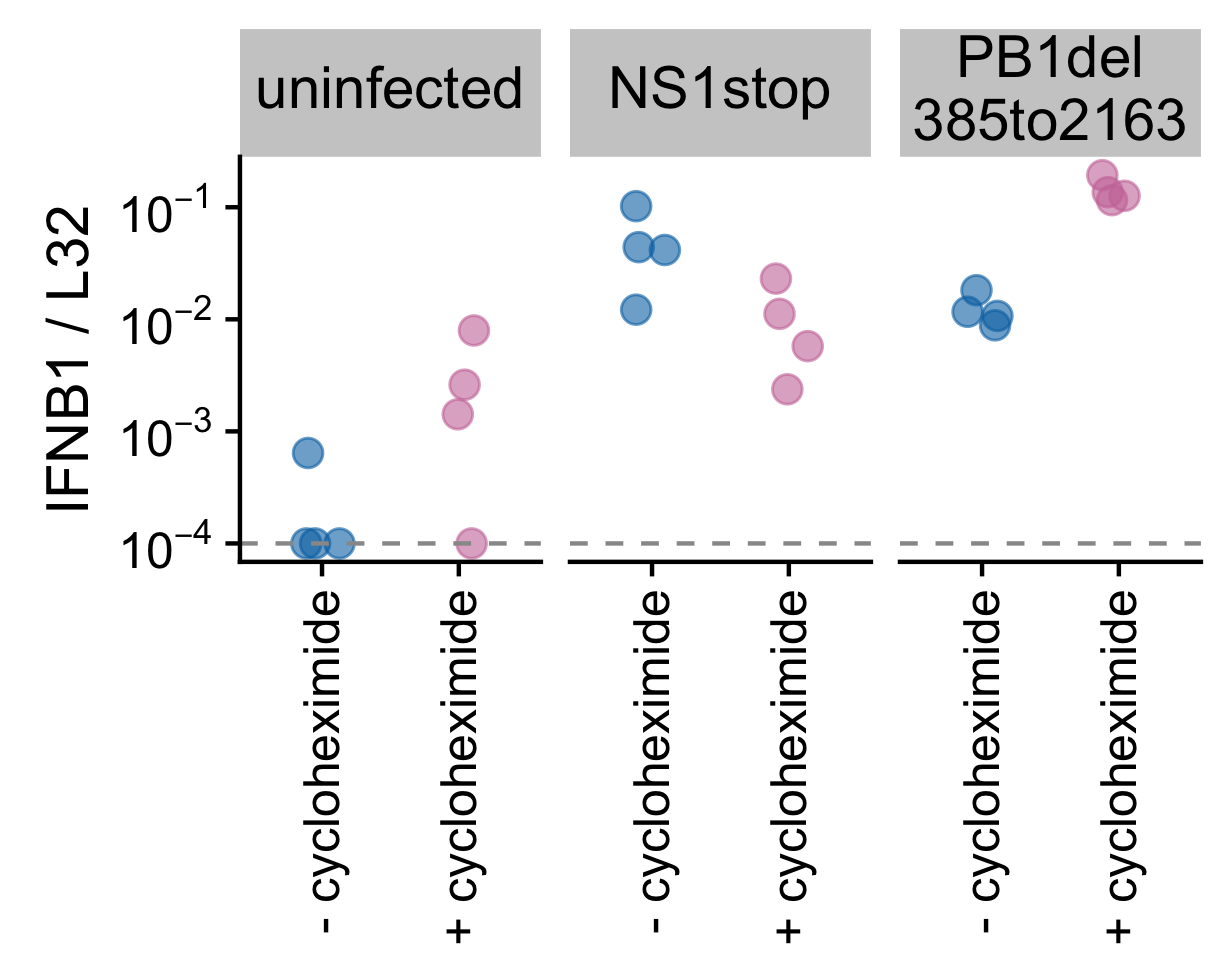

In [3]:
set.seed(1) # reproducible jittering

cyclo_qpcr_plot <- ggplot(
    cyclo_qPCR,
    aes(Cycloheximide, IFNB1, color=Cycloheximide)) +
  geom_jitter(height=0, width=0.15, size=3, alpha=0.6) +
  scale_y_log10(name="IFNB1 / L32", labels=fancy_scientific) +
  facet_wrap(~ Sample, nrow=1) +
  theme(
    legend.position='none',
    strip.text=element_text(size=14, margin=margin(b=3)),
    axis.text.x=element_text(angle=90, vjust=0.5, hjust=1, size=12),
    axis.title.x=element_blank()
    ) +
  scale_color_manual(values=c(cbPalette[6], cbPalette[8])) +
  geom_hline(yintercept=qPCR_limit,
             linetype='dashed',
             color=cbPalette[1])

saveShowPlot(cyclo_qpcr_plot, width=4.1, height=3.25)

### Cells treated with ribavirin
Now we do an analysis similar to above, but for cells treated with ribavirin.

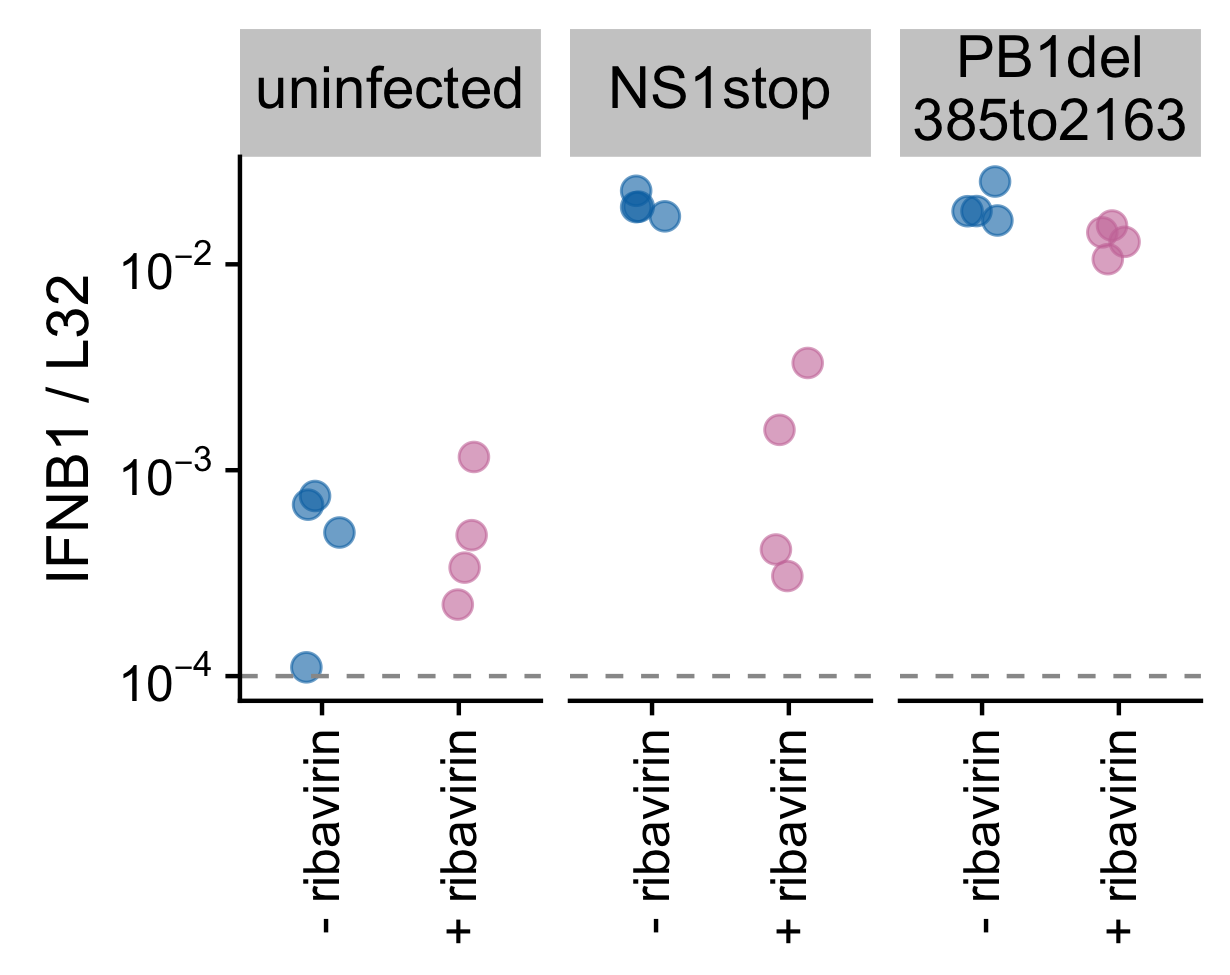

In [4]:
ribavirin_qPCR <- read.csv("qPCR/ribavirinandcomplement.csv") %>%
  mutate(
    Sample=recode(Sample,
      `NS1-stop`="NS1stop",
      Uninfected="uninfected",
      `PB1-d385-2163`="PB1del\n385to2163"
      ),
    Ribavirin=recode(Ribavirin,
      No="- ribavirin",
      Yes="+ ribavirin"
      )
    ) %>%
  filter(Sample %in% qPCR_samples) %>%
  transform(Sample=factor(Sample, qPCR_samples)) %>%
  mutate(IFNB1=pmax(IFNB1, qPCR_limit))

set.seed(1) # reproducible jittering

ribavirin_qpcr_plot <- ggplot(
    ribavirin_qPCR,
    aes(Ribavirin, IFNB1, color=Ribavirin)) +
  geom_jitter(height=0, width=0.15, size=3, alpha=0.6) +
  scale_y_log10(name="IFNB1 / L32", labels=fancy_scientific) +
  facet_wrap(~ Sample, nrow=1) +
  theme(
    legend.position='none',
    strip.text=element_text(size=14, margin=margin(b=3)),
    axis.text.x=element_text(angle=90, vjust=0.5, hjust=1, size=12),
    axis.title.x=element_blank()
    ) +
  scale_color_manual(values=c(cbPalette[6], cbPalette[8])) +
  geom_hline(yintercept=qPCR_limit,
             linetype='dashed',
             color=cbPalette[1])

saveShowPlot(ribavirin_qpcr_plot, width=4.1, height=3.25)

## Viral expression and IFN induction
Now we look at the relationship among expression of HA (a measure of viral load) and extent of IFN induction for wildtype and the IFN-inducing mutants that can still undergo secondary transcription.
This is designed to support the single-cell observation that NS-deficient viruses with higher flu induce more IFN, but that the same is not true for NS-containing viruses.

We look at the flow data that we have already plotted out for another analysis at [../Validation_Figure/analyze_flow.ipynb](../Validation_Figure/analyze_flow.ipynb).
We only examine wildtype and the mutants validated to increase IFN levels:

In [5]:
# directory with flow data
flowdir = '../Validation_Figure/flow/SNP/'

# samples
expression_samples <- list(
  'uninfected'='uninfected',
  'wild-type'='wildtype',
  'NS1mut'='NS1stop',
  'PB1_G103A'='PB1-D27N',
  'PB1_A2053G'='PB1-T677A',
  'NS_C391T'='NS1-A122V'
  )

# replicates for each sample
replicates <- lapply(
  names(expression_samples),
  function (Sample) {
    if (Sample == "uninfected")
      1:3
    else
      1:4
    }
  ) %>%
  setNames(names(expression_samples))

# read into data frame
expression_data <- lapply(
  names(expression_samples),
  function (Sample) {
    lapply(replicates[[Sample]],
      function (replicate) {
        paste0(flowdir, Sample, '_', replicate, '.csv') %>%
          read.csv %>%
          mutate(Sample=expression_samples[Sample],
                 replicate=replicate)
        }
      ) %>% 
      bind_rows
    }
  ) %>%
  bind_rows %>%
  rename(IFN=FITC.A,
         HA=APC.A) %>%
  select(Sample, replicate, IFN, HA)

Now we gate the HA+ and IFN+ cells based on the 99.95th percentile of the uninfected population, just like in the prior FACS analysis:

In [6]:
gate_threshold <- 0.9995

HA_threshold <- (expression_data %>% filter(Sample=="uninfected"))$HA %>% 
  quantile(c(gate_threshold)) %>% 
  unname

IFN_threshold <- (expression_data %>% filter(Sample=="uninfected"))$IFN %>% 
  quantile(c(gate_threshold)) %>% 
  unname

expression_data <- expression_data %>%
  mutate(HApos=HA > HA_threshold,
         IFNpos=IFN > IFN_threshold)

Now keep only uninfected samples, re-name replicates to match flow, and use log of flow values:

In [7]:
expression_data <- expression_data %>%
  filter(Sample != "uninfected") %>%
  mutate(logHA=log10(HA),
         logIFN=log10(IFN)) %>%
  transform(Sample=factor(Sample, unlist(expression_samples, use.names=FALSE))) %>%
  mutate(replicate=recode(replicate, `1`="1a", `2`="1b", `3`="2a", `4`="2b"))

Warning message in evalq(log10(HA), <environment>):
“NaNs produced”Warning message in evalq(log10(IFN), <environment>):
“NaNs produced”

Finally, make a plot.
We see that (as in the single-cell data) for NS1stop viruses, more viral load corresponds to more IFN.

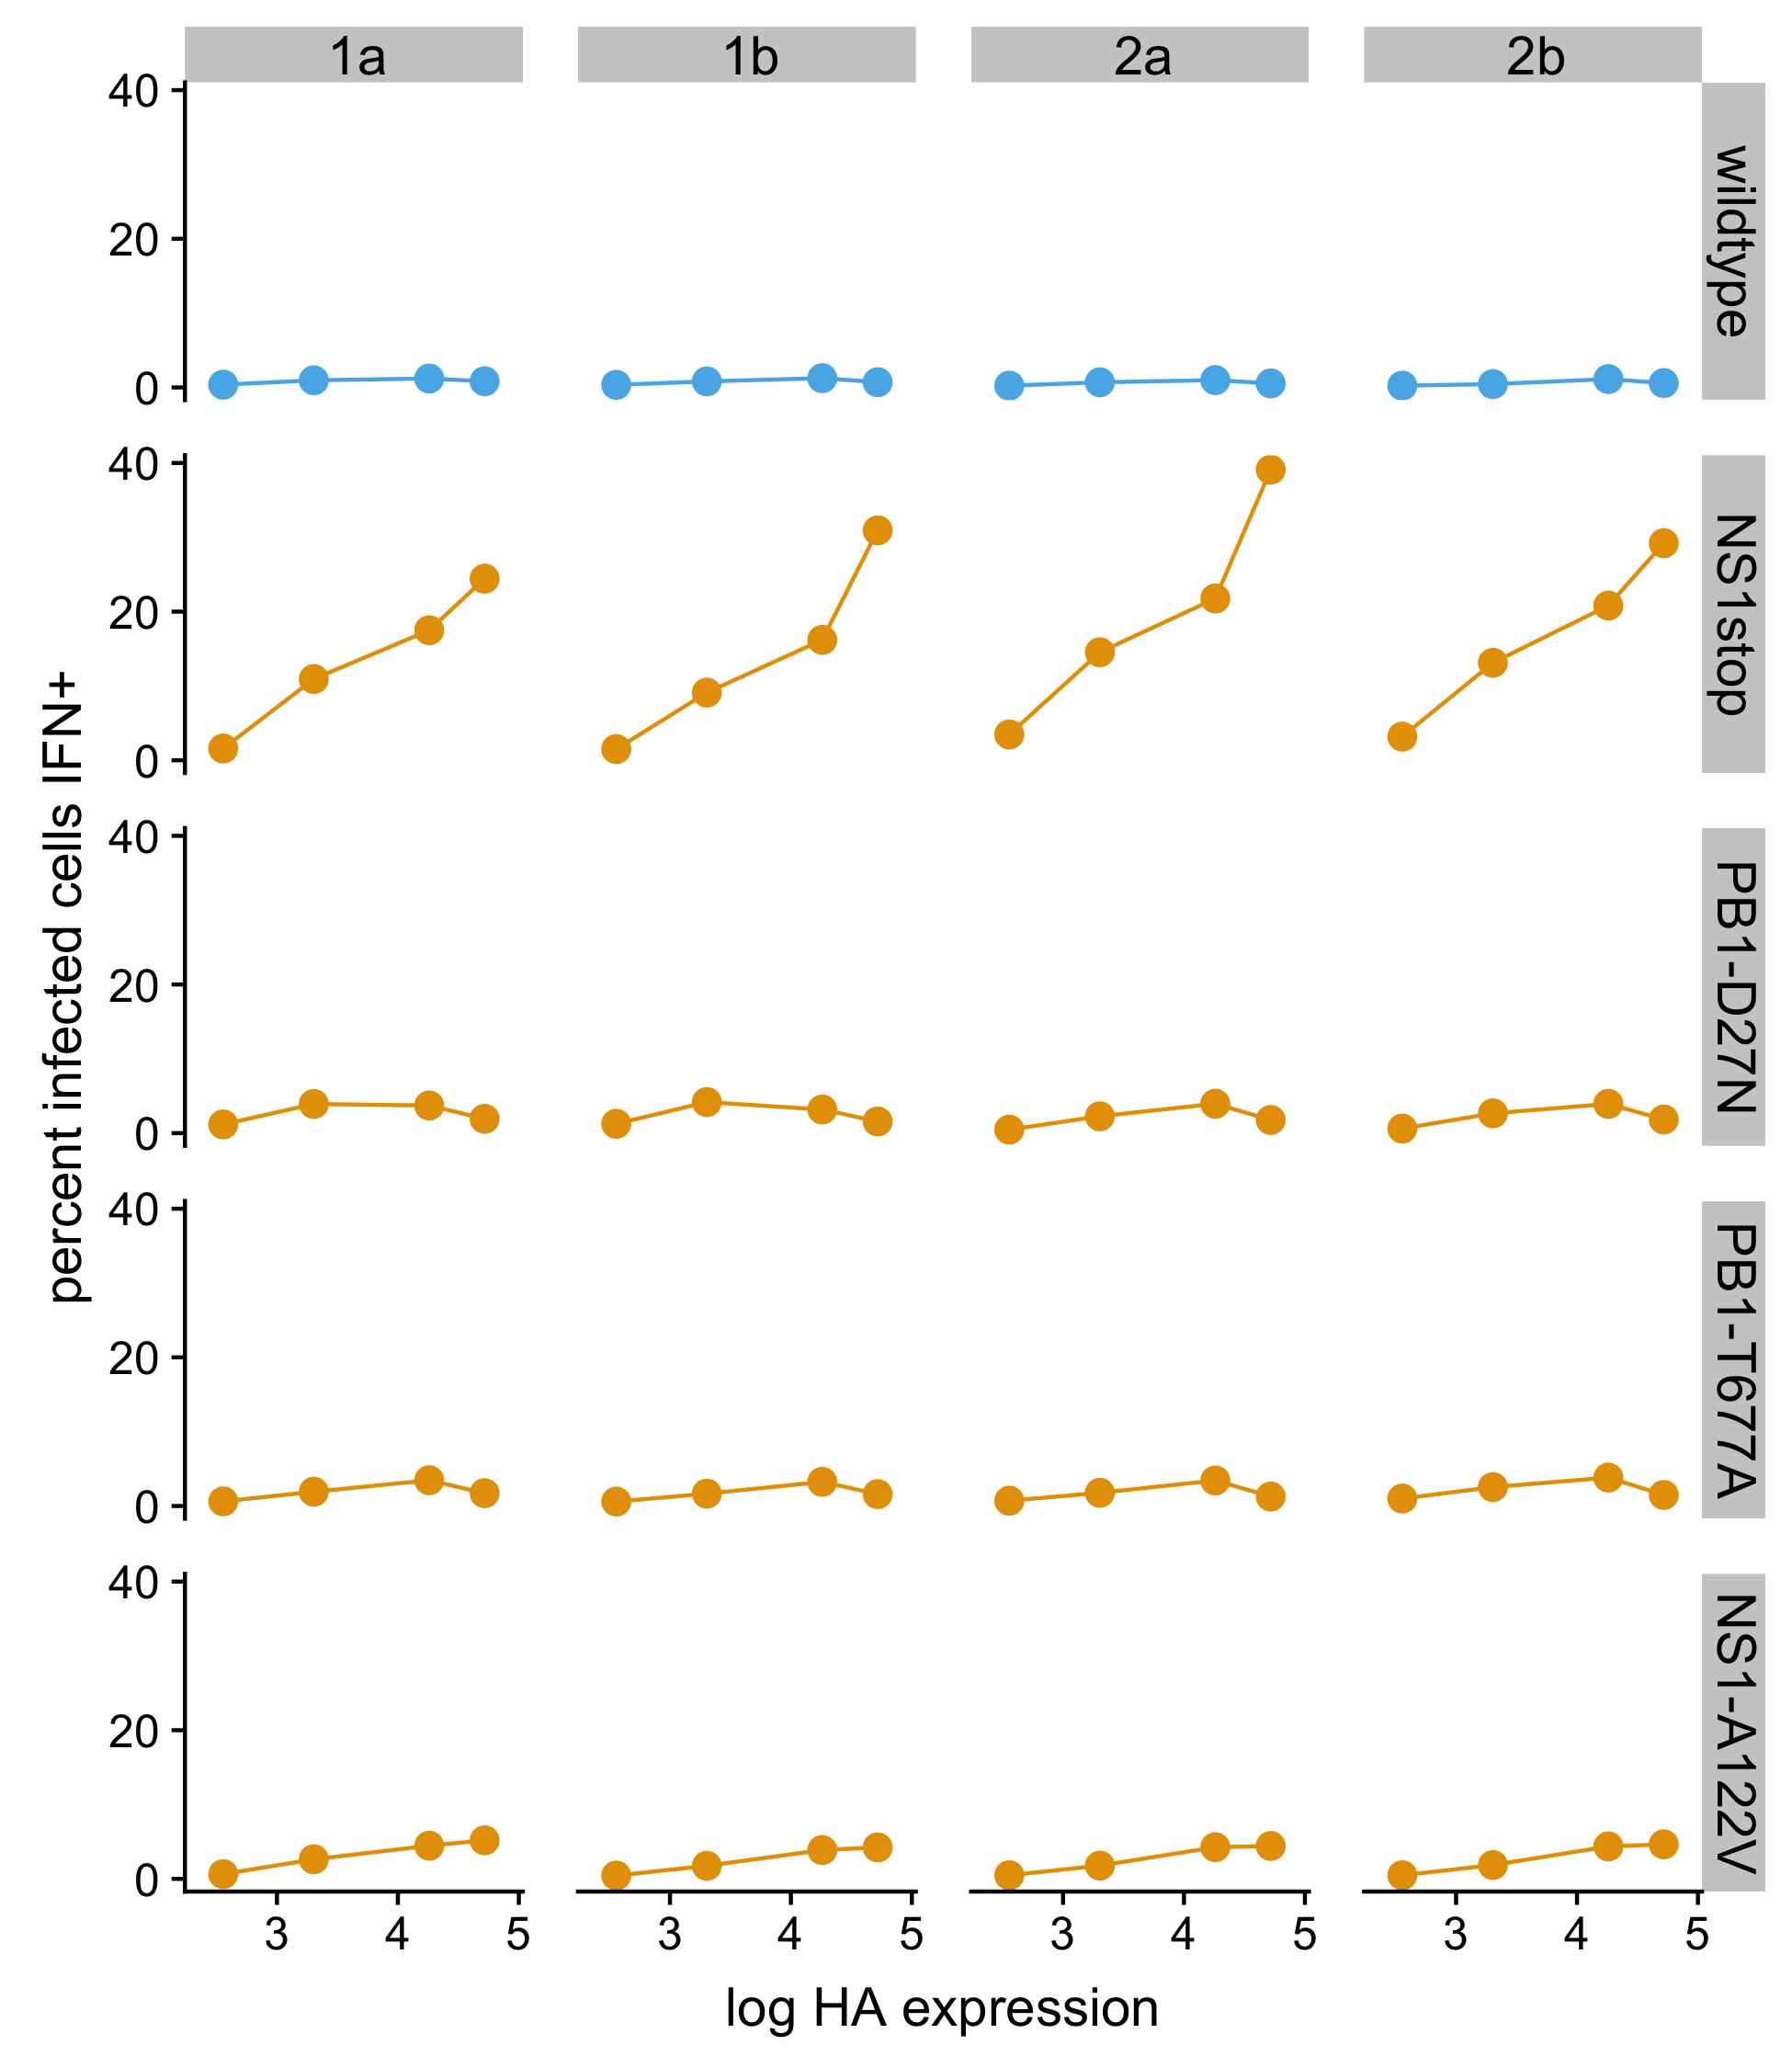

In [8]:
p_ifn_vs_ha <- ggplot(
    expression_data %>% 
      filter(HApos) %>% 
      group_by(Sample) %>%
      mutate(HAquintile=cut(logHA, breaks=4, labels=FALSE)) %>%
      group_by(HAquintile) %>%
      mutate(HAquintile_mean=mean(logHA)) %>%
      group_by(Sample, replicate, HAquintile_mean) %>%
      summarize(percent_IFNpos=100 * sum(IFNpos) / n()) %>%
      mutate(is_wildtype=(Sample == "wildtype")),
    aes(HAquintile_mean, percent_IFNpos, color=is_wildtype)) +
  geom_point(size=3) +
  geom_line() +
  facet_grid(Sample ~ replicate) +
  theme(strip.text=element_text(size=14, margin=margin(l=3, t=1, b=1, r=1)),
        panel.spacing=unit(1, "lines"),
        legend.position='none') +
  scale_y_continuous(name="percent infected cells IFN+", breaks=pretty_breaks(3)) +
  scale_x_continuous(name="log HA expression", breaks=pretty_breaks(3), expand=c(0.1, 0.1)) +
  scale_color_manual(values=cbPalette[2:3])

saveShowPlot(p_ifn_vs_ha, width=6.5, height=7.5)